In [1]:
%matplotlib inline
from IPython.display import HTML
from IPython.display import display, Markdown


HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Non-linear resonator dynamics simulation

The purpose of this notebook is to simulate ${\lambda}/{4}$ coplanar waveguide resonators, capacitively coupled to an open transmission line in a notch configuration.

<br>

<div>
<img src="attachment:TLS-Schematics.png" width="300"/>
</div>

These resonators are designed and assumed to behave linearly, described as a harmonic LC oscillator to a generally satisfactory degree. 
We explore whether defects and loss channels, such as parasitic TLS, can give rise to non-linearities that are overlooked in ideal models.

<br>

<div>
<img src="attachment:Setup-drawing.png" width="500"/>
</div>

<br>
Our goal is to simulate the internal dynamics of the resonator $(a)$.
Nevertheless, we only have direct access to information at the input $(a_{in})$ and output $(a_{out})$ of the system.
Therefore, to calculate the intra-cavity field we use input-output theory to obtain

$$ \dfrac{a_{out}}{e^{i\alpha}\sqrt{G}} = \dfrac{a_{in}}{e^{i\beta}\sqrt{\mathcal{A}}} + \lambda a \quad \rightarrow \quad a = \dfrac{1}{\lambda} e^{i\alpha} \left( \dfrac{a_{out}}{\sqrt{G}} - e^{i(\alpha-\beta)}\dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) $$

where $G$ and $\mathcal{A}$ are the gain and attenuation of the output and input line respectively, $\lambda$ represents the waveguide-resonator coupling rate, and $\alpha$ and $\beta$ simbolize the phase delays in the lines.
Notice that we only care about the phase difference, $\phi$, between the input and output line.

The dynamics of the resonator are described by the Heisenberg equation of motion 

$$ \dot{a} = -i \omega_r a - \kappa_0 a - \kappa_{TLS}(a) a + \dfrac{\lambda}{\sqrt{\mathcal{A}}}a_{in}, $$

where $\omega_r$ indicates the resonant frequency, $\kappa_0$ the linear dissipation and $\kappa_{TLS}(a)$ the non-linear dissipation due to the TLS of the cavity.

The TLS non-linear dissipation is given by

$$ \kappa_{TLS}(a) = \dfrac{ \kappa_{TLS}}{\sqrt{1+ \left( |a|/a_c \right)^2}}  $$

Including this expression in the equation of motion we get

$$ \dot{a} = -i \omega_r a - \kappa_0 a - \dfrac{ \kappa_{TLS}}{\sqrt{1+ \left( |a|/a_c \right)^2}} a + \dfrac{\lambda}{\sqrt{\mathcal{A}}}a_{in}. $$

We now rewrite this expression in terms of the output and input fields as

$$ \dfrac{\dot{a}_{out}}{\sqrt{G}} - e^{i\phi}\dfrac{\dot{a}_{in}}{\sqrt{\mathcal{A}}} = -i\omega_r \left( \dfrac{a_{out}}{\sqrt{G}} - e^{i\phi}\dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) - \kappa_0 \left( \dfrac{a_{out}}{\sqrt{G}} - e^{i\phi}\dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) - \dfrac{\kappa_{TLS}}{\sqrt{1 + \left( \left| \dfrac{a_{out}}{\sqrt{G}} - e^{i\phi}\dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right| / |\lambda|a_c \right)^2 }} \left( \dfrac{a_{out}}{\sqrt{G}} - e^{i\phi}\dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) + \lambda^2 e^{i\phi} \dfrac{a_{in}}{\sqrt{\mathcal{A}}} $$

We also consider two known drive tones of the form

$$ a_{in} = F_0 \left( \cos({\omega_1}t) + \cos({\omega_2}t) \right). $$

We then solve the differential equation numerically using the following parameters:

| Drive Parameters | System Parameters       |
|:-----------------|:------------------------|
| $F_0 = 1$        | $\omega_r = 0$          |
| $f_1 = -0.001$   | $\kappa_0 = 0.025$      |
| $f_2 = 0.001$    | $\kappa_{TLS} = 0.0025$ |
|                  | $a_{c} = 1$             |
|                  | $\phi = 0$              |
|                  | $\lambda = 1$           |

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.linalg
import ipywidgets as widgets
import winsound
from functools import partial
from scipy.integrate import ode
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from ipywidgets import interactive
from tqdm import tqdm
from scipy.optimize import curve_fit

plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['figure.constrained_layout.use'] = True

# Greek alphabet: α, β, γ, δ, ε, ζ, η, θ, ι, κ, λ, μ, ν, ξ, ο, π, ρ, ς, σ, τ, υ, φ, χ, ψ, ω

# Constants
π = np.pi

In [ ]:
# Functions
def eom_nonlinear(time, state, fr, kappa0, kappa_tls, ac, lambd, drives, ddrives, phi):
    # resonant frequency
    ωr = 2*π * fr
    
    # Phase difference
    phase_diff = np.exp(1.0j * phi)
    
    # state normalized by gain
    state_norm = state / np.sqrt(gain)
    
    # drives and its derivatives normalized by attenuation
    drives_norm = phase_diff * drives(time) / np.sqrt(att)
    ddrives_norm = phase_diff * ddrives(time) / np.sqrt(att)
    
    return  np.sqrt(gain) * (-1.0j*ωr*(state_norm-drives_norm) - kappa0*(state_norm-drives_norm) - kappa_tls/np.sqrt(1+((np.abs(state_norm-drives_norm)/(ac*lambd))**2))*(state_norm-drives_norm) + ddrives_norm + lambd**2*drives_norm)


def eom_nonlinear_real(time, state_real, fr, kappa0, kappa_tls, ac, lambd, drives, ddrives, phi):
    state_complex = state_real[::2] + 1j*state_real[1::2]
    ret_complex = eom_nonlinear(time, state_complex, fr, kappa0, kappa_tls, ac, lambd, drives, ddrives, phi)
    tmp = np.zeros(len(ret_complex)*2)
    tmp[::2] = np.real(ret_complex)
    tmp[1::2] = np.imag(ret_complex)
    
    return tmp


def imp_drive(time, fd1, fd2, B, φ1=0, φ2=0):
    # drive frequencies
    ω1 = 2*π * fd1
    ω2 = 2*π * fd2
    
    return B*(np.cos(ω1*time + φ1) + np.cos(ω2*time + φ2))


def imp_drive_derivative(time, fd1, fd2, B, φ1=0, φ2=0):
    # drive frequencies
    ω1 = 2*π * fd1
    ω2 = 2*π * fd2
    
    return -B*(ω1*np.sin(ω1*time + φ1) + ω2*np.sin(ω2*time + φ2))


def nonlinear_simulation(time, fr, kappa0, kappa_tls, ac, lambd, fd1, fd2, B, ind_drives, phi=0):
    # Drive tones
    drives = partial(imp_drive, fd1=fd1, fd2=fd2, B=B)
    ddrives = partial(imp_drive_derivative, fd1=fd1, fd2=fd2, B=B)
    
    # Integrator
    o = ode(eom_nonlinear_real).set_integrator('lsoda', atol=1e-11, rtol=1e-11)
    o.set_f_params(fr, kappa0, kappa_tls, ac, lambd, drives, ddrives, phi)
    o.set_initial_value(y0, 0)
    
    # Time-domain solution
    y_all = np.zeros((len(time), len(y0)))
    for i, t in enumerate(time):
        o.integrate(t)
        y_all[i] = o.y
        
    # Merge the results onto the complex plane
    field_all = y_all[:,0] + 1.0j*y_all[:,1]
    
    # We save one oscillation once we reached the steady state
    field = field_all[-N-1:-1]
    t = time[-N-1:-1]
    
    # Fourier domain solution
    Field = np.fft.fft(field) / len(field)
    freqs = np.fft.fftfreq(len(t), d=dt)
    
    # Generated drive array in the frequency and time domain
    Field_in = np.zeros_like(Field, dtype=complex)
    Field_in[ind_drives] = B
    field_in = np.fft.ifft(Field_in)
    field_in *= len(field_in)
    
    return Field, Field_in, field_all, field, field_in, freqs, t, drives


def recon_nonlinear(Field, Field_in, field, field_in, freqs, indices, order):
    # Angular frequency
    ω = 2*π * freqs
    
    # Create H-matrix
    col1 = (1.0j*ω*(Field/np.sqrt(gain) - Field_in/np.sqrt(att)))[indices]
    col2 = 1.0j*(Field/np.sqrt(gain) - Field_in/np.sqrt(att))[indices]
    col3 = (Field/np.sqrt(gain) - Field_in/np.sqrt(att))[indices]
    
    # Merge columns
    H = np.vstack((col1, col2, col3))
    
    # Non-linear damping terms
    for exp_ind, exp_val in enumerate(order):
        col = np.fft.fft(np.abs((field/np.sqrt(gain) - field_in/np.sqrt(att))) ** exp_val * (field / np.sqrt(gain) - field_in / np.sqrt(att)))[indices] / len(field)
        H = np.vstack((H, col))
    
    # Making the matrix real instead of complex
    Hcos = np.real(H)
    Hsin = np.imag(H)
    H = np.hstack((Hcos, Hsin))
    
    # Normalize H for a more stable inversion
    Nm = np.diag(1. / np.max(np.abs(H), axis=1))
    H_norm = np.dot(Nm, H)  # normalized H-matrix
    
    # The drive vector, Q (from the Yasuda paper)
    Qcos = np.real(Field_in/np.sqrt(att))[indices]
    Qsin = np.imag(Field_in/np.sqrt(att))[indices]
    Qmat = np.hstack((Qcos, Qsin))
    
    # Solve system Q = H*p
    H_norm_inv = scipy.linalg.pinv(H_norm)
    p_norm = np.dot(Qmat, H_norm_inv)
    
    # Re-normalize p-values
    # Note: we have actually solved Q = H * Nm * Ninv * p
    # Thus we obtained Ninv*p and multiply by Nm to obtain p
    p = np.dot(Nm, p_norm)  # re-normalize parameter values
    
    # Forward calculation to check result, should be almost everything zero vector
    Q_fit = np.dot(p, H)
    
    # Scale parameters by drive force assuming known resonant frequency
    param_recon = p
    
    # Parameters reconstructed
    lambda_recon = 1 / param_recon[0]
    fr_recon = lambda_recon * param_recon[1] / (2*π)
    kappa_arr = lambda_recon * param_recon[2:]
    
    return lambda_recon, fr_recon, kappa_arr, Q_fit


def plot_spectra(t_all_, y_all, t, y, yin, f_, Y, Yin, xlim_, ylim_, ind_arr):
    figure, axis = plt.subplots(4, 1, figsize=[12, 10])
    axis[0].plot(t_all_, np.abs(y_all) )
    axis[1].plot(t, np.abs(y), label='output field')
    axis[1].plot(t, np.abs(y/np.sqrt(gain)-yin/np.sqrt(att)), label='intra-cavity field')
    axis[2].semilogy(f_, np.abs(Y), label='output field')
    axis[2].semilogy(f_, np.abs(Y/np.sqrt(gain)-Yin/np.sqrt(att)), label='intra-cavity field')
    axis[2].semilogy(f_[ind_arr], np.abs(Y/np.sqrt(gain)-Yin/np.sqrt(att))[ind_arr], '.', label='reconstructed')
    axis[3].semilogy(f_, np.abs(Y), label='output field')
    axis[3].semilogy(f_, np.abs(Y/np.sqrt(gain)-Yin/np.sqrt(att)), label='intra-cavity field')
    axis[3].semilogy(f_[ind_arr], np.abs(Y/np.sqrt(gain)-Yin/np.sqrt(att))[ind_arr], '.', label='reconstructed')
    axis[0].set_ylabel('$|a|$ [a.u.]')
    axis[1].set_xlabel('time [s]')
    axis[1].set_ylabel('$|a|$ [a.u.]')
    axis[2].set_ylabel('$|\mathcal{F}(a)|$ [a.u.]')
    axis[3].set_ylabel('$|\mathcal{F}(a)|$ [a.u.]')
    axis[3].set_xlabel('frequency [Hz]')
    axis[2].set_ylim(*ylim_)
    axis[3].set_ylim(*ylim_)
    axis[3].set_xlim(*xlim_)
    axis[2].legend()
    return figure


# Plot the 3rd, 5th and 7th IMP strength as a function of drive power
def plot_paramdependence(param_arr, y, axis, ind_drives):
    axis.loglog(param_arr, np.abs(y[:, ind_drives[0]]), '.', label='drive 1')
    axis.loglog(param_arr, np.abs(y[:, ind_drives[1]]), '.', label='drive 2')
    axis.loglog(param_arr, np.abs(y[:, ind_drives[1]+2]), '.', label='3rd order' )
    axis.loglog(param_arr, np.abs(y[:, ind_drives[1]+4]), '.', label='5th order' )
    axis.loglog(param_arr, np.abs(y[:, ind_drives[1]+6]), '.', label='7th order' )
    axis.loglog(param_arr, np.abs(y[:, int(len(y[0])/2)]), '.', label='background' )
    axis.legend()

In [ ]:
# Gain and attenuation of the measurement lines
gain = 1
att = 1

# Drive parameters
λ = 0.5
F0 = 1
f1 = -0.001
f2 = 0.001
df = 0.001
fs = 20
N = int(round(fs/df))

# Drive indices
ind_drive = np.array([-1, 1])

# Imps indices
nimps = 40
imp_ind = np.arange(ind_drive[0]-nimps, ind_drive[1]+nimps+2, 2)

# Integration parameters
T = 1. / df
T_relax = 5 * T
dt = 1. / fs
t_all = dt*(np.arange((T+T_relax)/dt) + 1)

# System parameters
f0 = 0
κ0 = 0.025
κtls = 0.0025
ac = 1
Q_factor = 1/(2*κ0)

# Initial conditions
y0 = [0,0]

In [ ]:
# Simulation
A, Ain, a_all, a, ain, f, t_arr, drive = nonlinear_simulation(t_all, f0, κ0, κtls, ac, λ, f1, f2, F0, ind_drive)

In [ ]:
# Check that the generated drive matches with the simulated drive
verbose = False

if verbose:
    # Drive array in time domain
    ain_all_simu = drive(t_all)
    ain_simu = ain_all_simu[-N-1:-1]
    Ain_simu = np.fft.fft(ain_simu) / len(ain_simu)
    
    # Drives in time and frequency domain
    fig, ax = plt.subplots(3, 1, figsize=[9, 6])
    ax[0].plot(t_all, np.abs(ain_all_simu))
    ax[1].plot(t_arr, np.abs(ain_simu), label='Simulated')
    ax[1].plot(t_arr, np.abs(ain), label='Generated')
    ax[2].semilogy(f, np.abs(Ain_simu), label='Simulated')
    ax[2].semilogy(f, np.abs(Ain), label='Generated')
    ax[0].set_ylabel('$|a_{in}|$ [a.u.]')
    ax[1].set_xlabel('time [s]')
    ax[1].set_ylabel('$|a_{in}|$ [a.u.]')
    ax[2].set_xlabel('frequency [Hz]')
    ax[2].set_ylabel('$|\mathcal{F}(a_{in})|$ [a.u.]')
    ax[0].set_ylim(-0.1, 3)
    ax[2].set_ylim(1e-17, 1e3)
    ax[2].legend()

ylim = np.array([1e-16, 1e3])
xlim = np.array([-0.1, 0.1])
fig1 = plot_spectra(t_all, a_all, t_arr, a, ain, f, A, Ain, xlim, ylim, imp_ind)
plt.show()

## Parameter dependence

We now want to analyze the behaviour of the IMP spectra as a function of the different parameters of the system.
This may help us to select an appropiate value for $\kappa_0$, $\kappa_{TLS}$ and $a_c$ to imitate as much as possible the experimental results.
These sweeps may also help us to get a better intuition of the system itself.

### $\kappa_0$ sweep

We start by sweeping the linear damping coefficient $\kappa_0 \in [0.01, 10]$ while keeping the rest of the parameters fixed to the values stated in the table above. (Pretty arbitrary values though)

In [ ]:
# κ0 sweep values
κ0_arr = np.logspace(-3, 1, 51)

# Spectra arrays
A_κ0 = np.zeros((len(κ0_arr), N), dtype=np.complex)
Ain_κ0 = np.zeros_like(A_κ0)
a_all_κ0 = np.zeros((len(κ0_arr), len(t_all)), dtype=np.complex)
a_κ0 = np.zeros_like(A_κ0)
ain_κ0 = np.zeros_like(A_κ0)

# κ0 sweep
with tqdm(total=len(κ0_arr), ncols=80) as pbar:

    for κ0_ind, κ0_val in enumerate(κ0_arr):
        # Simulation section
        A_κ0[κ0_ind], Ain_κ0[κ0_ind], a_all_κ0[κ0_ind], a_κ0[κ0_ind], ain_κ0[κ0_ind], f_κ0, t_κ0, drive_κ0 = nonlinear_simulation(t_all, f0, κ0_val, κtls, ac, λ, f1, f2, F0, ind_drive)
        
        pbar.update(1)

In [ ]:
def κ0_sweep(κ0_ind_):
    # Intra-cavity field in time and frequency domain
    ylim = np.array([1e-17, 1e4])
    xlim = np.array([-0.1, 0.1])
    figure = plot_spectra(t_all, a_all_κ0[κ0_ind_], t_κ0, a_κ0[κ0_ind_], ain_κ0[κ0_ind_], f_κ0, A_κ0[κ0_ind_], Ain_κ0[κ0_ind_], xlim, ylim, imp_ind)
    figure.suptitle(f'$\kappa_0$ = {κ0_arr[κ0_ind_]:.5f}')
    
# Interactive layout  
widgets.interact(κ0_sweep,
                 κ0_ind_=widgets.IntSlider(min=0,
                                           max=len(κ0_arr)-1,
                                           step=1,
                                           description='κ0_ind',
                                           )
                )

plt.show()

In [ ]:
fig3, ax3 = plt.subplots(1)
plot_paramdependence(κ0_arr, A_κ0, ax3, ind_drive)
ax3.set_xlabel('$\kappa_{0}$ [a.u.]')
ax3.set_ylabel('$|\mathcal{F}(a)|$ [a.u.]')
plt.show()

Analyzing the last figure, we observe a couple of things.

At low $\kappa_0$ values the background is significantly high (and not noisy). 
This characteristic can be explained by looking at the spectra at low $\kappa_0$ values. 
To be honest, I do not quite understand why the noise floor looks like that at low $\kappa_0$ values. 
It may be due to the integrator or the tolerances I use to solve the differential equation.

Moreover, the drive and IMP amplitudes diminish as the linear damping increases.
This makes sense since the higher damping the lower the linearized Q factor of the resonance.

### $\kappa_{TLS}$ sweep

We then sweep the TLS non-linear damping parameter $\kappa_{TLS} \in [1\cdot10^{-4}, 10]$, while fixing the rest of the parameters.

In [ ]:
# κtls sweep values
κtls_arr = np.logspace(-4, 1, 51)

# Spectra arrays
A_κtls = np.zeros((len(κtls_arr), N), dtype=np.complex)
Ain_κtls = np.zeros_like(A_κtls)
a_all_κtls = np.zeros((len(κtls_arr), len(t_all)), dtype=np.complex)
a_κtls = np.zeros_like(A_κtls)
ain_κtls = np.zeros_like(A_κtls)

# κtls sweep
with tqdm(total=len(κtls_arr), ncols=80) as pbar:

    for κtls_ind, κtls_val in enumerate(κtls_arr):
        # Simulation section
        A_κtls[κtls_ind], Ain_κtls[κtls_ind], a_all_κtls[κtls_ind], a_κtls[κtls_ind], ain_κtls[κtls_ind], f_κtls, t_κtls, drive = nonlinear_simulation(t_all, f0, κ0, κtls_val, ac, λ, f1, f2, F0, ind_drive)
        
        pbar.update(1)

In [ ]:
def κtls_sweep(κtls_ind_):
    # Intra-cavity field in time and frequency domain
    ylim = np.array([1e-17, 1e3])
    xlim = np.array([-0.1, 0.1])
    figure = plot_spectra(t_all, a_all_κtls[κtls_ind_], t_κtls, a_κtls[κtls_ind_], ain_κtls[κtls_ind_], f_κtls, A_κtls[κtls_ind_], Ain_κtls[κtls_ind_], xlim, ylim, imp_ind)
    figure.suptitle('$\kappa_{TLS}$ = ' + f'{κtls_arr[κtls_ind_]:.5f}')
    
# Interactive layout  
widgets.interact(κtls_sweep,
                 κtls_ind_=widgets.IntSlider(min=0,
                                             max=len(κtls_arr)-1,
                                             step=1,
                                             description='κtls_ind',
                                             )
                )

plt.show()

In [ ]:
# Plot the 3rd, 5th and 7th IMP strength as a function of drive power
fig4, ax4 = plt.subplots(1)
plot_paramdependence(κtls_arr, A_κtls, ax4, ind_drive)
ax4.set_xlabel('$\kappa_{TLS}$ [a.u.]')
ax4.set_ylabel('$|\mathcal{F}(a)|$ [a.u.]')
plt.show()

The drive amplitudes remain constant up to roughly $\kappa_{TLS}=0.5$, where the amplitudes start to decay a bit.
Regarding the IMP amplitudes, they increase as $\kappa_{TLS}$ increases, but they significantly drop after $\kappa_{TLS}=0.5$.
One possible explanation to this behaviour is that as we increase the non-linear damping, we increase the non-linearity generating stronger IMPs, while keeping the drives untouched.
However, at this critical $\kappa_{TLS}$ value, the non-linearity is too strong and starts affecting the drives causing this amplitude drop.

We also notice that now we do not have this background problem.

### $a_{c}$ sweep

Eventually we sweep the critical amplitude parameter $a_c \in [1\cdot10^{-4}, 100]$, while fixing the rest of the parameters.

In [ ]:
# ac sweep values
ac_arr = np.logspace(-4, 2, 51)

# Spectra arrays
A_ac = np.zeros((len(ac_arr), N), dtype=np.complex)
Ain_ac = np.zeros_like(A_ac)
a_all_ac = np.zeros((len(ac_arr), len(t_all)), dtype=np.complex)
a_ac = np.zeros_like(A_ac)
ain_ac = np.zeros_like(A_ac)

# ac sweep
with tqdm(total=len(ac_arr), ncols=80) as pbar:

    for ac_ind, ac_val in enumerate(ac_arr):
        # Simulation section
        A_ac[ac_ind], Ain_ac[ac_ind], a_all_ac[ac_ind], a_ac[ac_ind], ain_ac[ac_ind], f_ac, t_ac, drive = nonlinear_simulation(t_all, f0, κ0, κtls, ac_val, λ, f1, f2, F0, ind_drive)
        
        pbar.update(1)

In [ ]:
np.shape(a_all_ac)

In [ ]:
def ac_sweep(ac_ind_):
    # Intra-cavity field in time and frequency domain
    ylim = np.array([1e-17, 1e3])
    xlim = np.array([-0.1, 0.1])
    figure = plot_spectra(t_all, a_all_ac[ac_ind_], t_ac, a_ac[ac_ind_], ain_ac[ac_ind_], f_ac, A_ac[ac_ind_], Ain_ac[ac_ind_], xlim, ylim, imp_ind)
    figure.suptitle(f'$a_c$ = {ac_arr[ac_ind_]:.5f}')
    
# Interactive layout  
widgets.interact(ac_sweep,
                 ac_ind_=widgets.IntSlider(min=0,
                                           max=len(ac_arr)-1,
                                           step=1,
                                           description='ac_ind',
                                           )
                )

plt.show()

In [ ]:
# Plot the 3rd, 5th and 7th IMP strength as a function of drive power
fig5, ax5 = plt.subplots(1)
plot_paramdependence(ac_arr, A_ac, ax5, ind_drive)
ax5.set_xlabel('$a_c$ [a.u.]')
ax5.set_ylabel('$|\mathcal{F}(a)|$ [a.u.]')
plt.show()

As $a_c$ increases the non-linearity increases (similarly as increasing $\kappa_{TLS}$), and therefore the IMP amplitudes increase.
For $a_c > 1$, the IMP strengths diminish meaning that the non-linearity is too strong. 

### Phase difference sweep

So far we have considered the phase delay in the input and output lines to be the same, i.e. $\phi = \alpha-\beta = 0$.
However, this assumption is probably not reasonable.
Therefore, we simulate the system taking into account phase delays and sweeping the phase difference parameter $\phi \in (0,2\pi)$, while fixing the rest of the parameters.

In [ ]:
# Phase Sweep
φ_arr = np.linspace(0, 2*π, 51)

# Spectra arrays
A_φ = np.zeros((len(φ_arr), N), dtype=np.complex)
Ain_φ = np.zeros_like(A_φ)
a_all_φ = np.zeros((len(φ_arr), len(t_all)), dtype=np.complex)
a_φ = np.zeros_like(A_φ)
ain_φ = np.zeros_like(A_φ)

# Power sweep
with tqdm(total=len(φ_arr), ncols=80) as pbar:

    for φ_ind, φ_val in enumerate(φ_arr):
        # Simulation section
        A_φ[φ_ind], Ain_φ[φ_ind], a_all_φ[φ_ind], a_φ[φ_ind], ain_φ[φ_ind], f_φ, t_φ, drive = nonlinear_simulation(t_all, f0, κ0, κtls, ac, λ, f1, f2, F0, ind_drive, φ_val)
        
        pbar.update(1)

In [ ]:
def phi_sweep(phi_ind):
    # Intra-cavity field in time and frequency domain
    ylim = np.array([1e-17, 1e4])
    xlim = np.array([-0.1, 0.1])
    figure = plot_spectra(t_all, a_all_φ[phi_ind], t_φ, a_φ[phi_ind], ain_φ[phi_ind], f_φ, A_φ[phi_ind], Ain_φ[phi_ind], xlim, ylim, imp_ind)
    figure.suptitle(f'$\phi$ = {φ_arr[phi_ind]:.5f}')
    
# Interactive layout  
widgets.interact(phi_sweep,
                 phi_ind=widgets.IntSlider(min=0,
                                           max=len(φ_arr)-1,
                                           step=1,
                                           description='φ_ind',
                                           )
                )

plt.show()

As we sweep the phase difference parameter, the intra-cavity field increases and decreases.
We suspect due to constructive and destructive interference, since at $\phi=\pi$ the intra-cavity field is maximum and higher than the output field, whereas at $\phi=0$, the field is minimum.

Regarding the frequency domain spectra, no relevant changes are appreciated in the amount of IMPs and in their strength.

In [ ]:
# Plot the 3rd, 5th and 7th IMP strength as a function of drive power
fig7, ax7 = plt.subplots(1)
plot_paramdependence(φ_arr, A_φ, ax7, ind_drive)
ax7.set_xlabel('$\phi$ [a.u.]')
ax7.set_ylabel('$|\mathcal{F}(a)|$ [a.u.]')
ax7.legend()
plt.show()

The drive and IMP magnitudes remain constant.

### Power dependence

We analyze the power dependence of the IMPs as a function of the drive power.
For that we sweep the parameter $F_0$.


In [ ]:
# Power Sweep
F0_arr = np.logspace(-4, 2, 201)

# Spectra arrays
A_F0 = np.zeros((len(F0_arr), N), dtype=np.complex)
Ain_F0 = np.zeros_like(A_F0)
a_all_F0 = np.zeros((len(F0_arr), len(t_all)), dtype=np.complex)
a_F0 = np.zeros_like(A_F0)
ain_F0 = np.zeros_like(A_F0)

# Power sweep
with tqdm(total=len(F0_arr), ncols=80) as pbar:

    for F0_ind, F0_val in enumerate(F0_arr):
        # Simulation section
        A_F0[F0_ind], Ain_F0[F0_ind], a_all_F0[F0_ind], a_F0[F0_ind], ain_F0[F0_ind], f_F0, t_F0, drive = nonlinear_simulation(t_all, f0, κ0, κtls, ac, λ, f1, f2, F0_val, ind_drive)
        
        pbar.update(1)

In [ ]:
def amp_sweep(amp_ind):
    # Intra-cavity field in time and frequency domain
    ylim = np.array([1e-19, 1e4])
    xlim = np.array([-0.1, 0.1])
    figure = plot_spectra(t_all, a_all_F0[amp_ind], t_F0, a_F0[amp_ind], ain_F0[amp_ind], f_F0, A_F0[amp_ind], Ain_F0[amp_ind], xlim, ylim, imp_ind)
    figure.suptitle(f'$F_0$ = {F0_arr[amp_ind]:.5f}')
# Interactive layout  
widgets.interact(amp_sweep,
                 amp_ind=widgets.IntSlider(min=0,
                                           max=len(F0_arr)-1,
                                           step=1,
                                           description='F0_ind',
                                           )
                )

plt.show()

In [ ]:
# Plot the 3rd, 5th and 7th IMP strength as a function of drive power
fig6, ax6 = plt.subplots(1)
plot_paramdependence(F0_arr, A_F0, ax6, ind_drive)
ax6.set_xlabel('$F_0$ [a.u.]')
ax6.set_ylabel('$|\mathcal{F}(a)|$ [a.u.]')
ax6.legend()
plt.show()

At high (what is high? what is low?) pump powers, the IMP amplitudes remain constant, whereas at really low drive amplitudes they slightly decay.
This characteritic is not too different from the behaviour we (we as Janka) experimentally observed, where the IMP strength remains constant in some power range.

## Harmonic balance reconstruction

We now want to reconstruct the simulated system using harmonic balance. 
We first expand the square root of the TLS non-linear damping term as

$$ \kappa_{TLS}(a) = \dfrac{ \kappa_{TLS}}{\sqrt{1+ \left( |a|/a_c \right)^2}} = \kappa_{TLS} \left( 1 - \dfrac{1}{2} \left( \dfrac{|a|}{a_c} \right)^2 + \dfrac{3}{8} \left( \dfrac{|a|}{a_c} \right)^4 + \mathcal{O}(a^6) \right)  $$

Thus, the equation of motion up to $4^{th}$ order is given by

$$ \dfrac{\dot{a}_{out}}{\sqrt{G}} - e^{i\phi}\dfrac{\dot{a}_{in}}{\sqrt{\mathcal{A}}} = -i \omega_r \left( \dfrac{a_{out}}{\sqrt{G}} - e^{i\phi}\dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) - (\kappa_0+\kappa_{TLS}) \left( \dfrac{a_{out}}{\sqrt{G}} - e^{i\phi}\dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) + \dfrac{\kappa_{TLS}}{2 \lambda^2 a_c^2} \left| \dfrac{a_{out}}{\sqrt{G}} - e^{i\phi}\dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right|^2 \left( \dfrac{a_{out}}{\sqrt{G}} - e^{i\phi}\dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) - \dfrac{3 \kappa_{TLS}}{8 \lambda^4 a_c^4} \left| \dfrac{a_{out}}{\sqrt{G}} - e^{i\phi}\dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right|^4 \left( \dfrac{a_{out}}{\sqrt{G}} - e^{i\phi}\dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) + \lambda^2 e^{i\phi}\dfrac{a_{in}}{\sqrt{\mathcal{A}}}. $$

For simplicity, we express the previous equation as

$$ \dfrac{\dot{a}_{out}}{\sqrt{G}} - e^{i\phi}\dfrac{\dot{a}_{in}}{\sqrt{\mathcal{A}}} = -i \omega_r \left( \dfrac{a_{out}}{\sqrt{G}} - e^{i\phi}\dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) - \kappa_1 \left( \dfrac{a_{out}}{\sqrt{G}} - e^{i\phi}\dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) - \kappa_3 \left| \dfrac{a_{out}}{\sqrt{G}} - e^{i\phi}\dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right|^2 \left( \dfrac{a_{out}}{\sqrt{G}} - e^{i\phi}\dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) - \dots - \kappa_n \left| \dfrac{a_{out}}{\sqrt{G}} - e^{i\phi}\dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right|^{n-1} \left( \dfrac{a_{out}}{\sqrt{G}} - e^{i\phi}\dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) + \lambda^2 e^{i\phi}\dfrac{a_{in}}{\sqrt{\mathcal{A}}}. $$

We translate this expression into the Fourier domain, leading to

$$ i \omega_k \left( \dfrac{\dot{A}_{out,k}}{\sqrt{G}} - e^{i\phi}\dfrac{\dot{A}_{in,k}}{\sqrt{\mathcal{A}}} \right) + i \omega_r \left( \dfrac{A_{out,k}}{\sqrt{G}} - e^{i\phi}\dfrac{A_{in,k}}{\sqrt{\mathcal{A}}} \right) + \kappa_1 \left( \dfrac{A_{out,k}}{\sqrt{G}} - e^{i\phi}\dfrac{A_{in,k}}{\sqrt{\mathcal{A}}} \right) + \kappa_3 \mathscr{F}\left\{ \left| \dfrac{a_{out}}{\sqrt{G}} - e^{i\phi}\dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right|^2 \left( \dfrac{a_{out}}{\sqrt{G}} - e^{i\phi}\dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) \right\}_k + \dots + \kappa_n \mathscr{F}\left\{ \left| \dfrac{a_{out}}{\sqrt{G}} - e^{i\phi}\dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right|^{n-1} \left( \dfrac{a_{out}}{\sqrt{G}} - e^{i\phi}\dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) \right\}_k = \lambda^2 e^{i\phi}\dfrac{A_{in,k}}{\sqrt{\mathcal{A}}}. $$

In matrix form we have

$$ \underbrace{\begin{pmatrix} i \omega_k \left( \dfrac{\dot{A}_{out,k}}{\sqrt{G}} - e^{i\phi}\dfrac{\dot{A}_{in,k}}{\sqrt{\mathcal{A}}} \right) & i \left( \dfrac{A_{out,k}}{\sqrt{G}} - e^{i\phi}\dfrac{A_{in,k}}{\sqrt{\mathcal{A}}} \right) & \dfrac{A_{out,k}}{\sqrt{G}} - e^{i\phi}\dfrac{A_{in,k}}{\sqrt{\mathcal{A}}} & \mathscr{F}\left\{ \left| \dfrac{a_{out}}{\sqrt{G}} - e^{i\phi}\dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right|^2 \left( \dfrac{a_{out}}{\sqrt{G}} - e^{i\phi}\dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) \right\}_k & \dots & \mathscr{F}\left\{ \left| \dfrac{a_{out}}{\sqrt{G}} - e^{i\phi}\dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right|^{n-1} \left( \dfrac{a_{out}}{\sqrt{G}} - e^{i\phi}\dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right) \right\}_k \end{pmatrix}}_{\bar{\bar{H}}}  \underbrace{\begin{pmatrix} 1/\lambda^2 \\ \omega_r/\lambda^2 \\ \kappa_1/\lambda^2 \\ \kappa_3/\lambda^2 \\ \vdots \\\kappa_n/\lambda^2 \end{pmatrix}}_{\bar{p}} = \underbrace{e^{i\phi}\dfrac{A_{in,k}}{\sqrt{\mathcal{A}}}}_{\bar{q}}. $$

In this way we divide the problem into a matrix $\bar{\bar{H}}$ containing the measurement information, a vector $\bar{p}$ with all the unknown parameters and another vector $\bar{q}$ containing the driving terms. To obtain the least squares best fit to the unknown parameters of the system, we use the pseudo-inverse of matrix $\bar{\bar{H}}$ such that
$$ \bar{p} = \bar{\bar{H}}^+ \bar{q}. $$

To check how many terms we need in the reconstruction, we simulate the damping term (blue line) given by

$$ \kappa_0 + \dfrac{ \kappa_{TLS}}{\sqrt{1+ \left( |a|/a_c \right)^2}}. $$

We then fit a polynomial (red line)

$$ \kappa_1 + \kappa_3 a^2 + \kappa_5 a^4 + \mathcal{O}(a^6). $$

Depending on the range of |a| we will need more or less polynmial coefficients to properly fit the TLS damping.
We are interested in small |a|. 
Therefore we pick the following parameters for the system as an initial attempt to reconstruction.

| Drive Parameters | System Parameters       |
|:-----------------|:------------------------|
| $F_0 = 1$        | $\omega_r = 0$          |
| $f_1 = -0.001$   | $\kappa_0 = 0.5$      |
| $f_2 = 0.001$    | $\kappa_{TLS} = 0.05$ |
|                  | $a_{c} = 1$             |
|                  | $\phi = 0$              |
|                  | $\lambda = 1$           |

We plot the damping as a function of |a| (blue line) and the polynomial fit (red dotted line) up to the nth order.

In [ ]:
# TLS damping function
def tls_function(x, κ0_, κtls_, ac_ ):
    return κ0_ + κtls_/np.sqrt(1 + (x/ac_)**2)

# Parameters
# Drive parameters
λ = 1
F0 = 1
f1 = -0.001
f2 = 0.001
df = 0.001
fs = 20
N = int(round(fs/df))

# Drive indices
ind_drive = np.array([-1, 1])

# Imps indices
nimps = 40
imp_ind = np.arange(ind_drive[0]-nimps, ind_drive[1]+nimps+2, 2)

# Integration parameters
T = 1. / df
T_relax = 5 * T
dt = 1. / fs
t_all = dt*(np.arange((T+T_relax)/dt) + 1)

# System parameters
κ0 = 0.5
κtls = 0.05
ac = 1
Q_factor = 1/(2*κ0)

# Initial conditions
y0 = [0,0]

# Gain and attenuation of the input and output lines
gain = 10 ** (0 / 10)
att = 10 ** (0 / 10)


# We simulate the TLS non-linearity
x_sim = np.linspace(0, 5, 1000)
y_sim = tls_function(x_sim, κ0, κtls, ac)

# Polynomial fit up to nth order
n = np.arange(0, 19, 2)
coefficients = np.polynomial.polynomial.polyfit(x_sim, y_sim, n)

# Fit data
y_fit = 0
print('\033[1m' + 'FIT PARAMETERS' + '\033[0m')
for coef_ind, coef_val in enumerate(coefficients):
    y_fit += coef_val*x_sim**coef_ind
    if coef_ind%2 == 0:
        print(f'κ{coef_ind+1} = {coef_val:.3e}')

# Plot
fig7, ax7 = plt.subplots(1)
ax7.plot(x_sim, y_sim)
ax7.plot(x_sim, y_fit, 'r--')
ax7.set_xlabel('|a| [a.u.]')
ax7.set_ylabel('Damping')
plt.show()

In [ ]:
# Simulation
A, Ain, a_all, a, ain, f, t_arr, drive = nonlinear_simulation(t_all, f0, κ0, κtls, ac, λ, f1, f2, F0, ind_drive)

Before simulating the dynamics, we need to consider that experimentally we measure the frequency components of a real valued voltage.
Therefore, in order to make the simulations more similar to the actual experiment, we need to use only the real part of the time-domain field $(a)$ to compute the frequency-domain field $A_r$ as

$$ A_r = \mathscr{R}\left\{ \text{Re}(a) \right\}. $$

Then, with this magnitude, we reconstruct the complex time-domain field as

$$ a = \text{Re}(a) + i \mathscr{R}^{-1}\left\{ i\omega A_r \right\}. $$

We then simulate the dynamics of the system with the previous parameters in both cases, taking the complex and only the real time-domain field.

In [ ]:
# In the experiment we only have access to a real signal (for example the voltage)
rfield = np.real(a)
t = t_all[-N-1:-1]

# Fourier transform of the real time domain spectra
rField = np.fft.rfft(rfield) / len(rfield)
rfreqs = np.fft.rfftfreq(len(t), d=dt)

# We calculate the complex field in the time and frequency domain using the real spectra
field = rfield + 1.0j*np.fft.irfft(1.0j*2*π*rfreqs*rField)*len(rfield)/(2*π)
Field = np.fft.fft(field) / len(field)
freqs = np.fft.fftfreq(len(t), d=dt)

ylim = np.array([1e-18, 1e3])
xlim = np.array([-0.1, 0.1])
fig8 = plot_spectra(t_all, a_all, t_arr, a, ain, f, A, Ain, xlim, ylim, imp_ind)
fig8.suptitle('Dynamics taking the real and imaginary components of the time domain field')
fig9 = plot_spectra(t_all, a_all, t_arr, field, ain, freqs, Field, Ain, xlim, ylim, imp_ind)
fig9.suptitle('Dynamics taking the real component of the time domain field')
plt.show()

Both fields look similar (at least near resonance), meaning that we are able to obtain the frequency-domain field using only the real part of the time-domain data.

We eventually perform a polynomial reconstruction obtaining the following coefficients

In [ ]:
# Number of terms of the polynomial reconstruction
recon_order = np.arange(2, 19, 2)

# Reconstruction using the complex time-domain spectra
λ_recon, f0_recon, κ_recon, Qmat_fit = recon_nonlinear(A, Ain, a, ain, f, imp_ind, recon_order)
λ_recon = np.sqrt(λ_recon)

# Reconstruction using only the real time-domain spectra
rλ_recon, rf0_recon, rκ_recon, rQmat_fit = recon_nonlinear(Field, Ain, field, ain, f, imp_ind, recon_order)
rλ_recon = np.sqrt(rλ_recon)

# Print results
print('\033[1m' + 'RECONSTRUCTED PARAMETERS')
print('{:<15} {:<15} {:<15}'.format('Parameter','Complex','Real') + '\033[0m')
print('{:<15} {:<15} {:<15}'.format('f0_recon', f'{f0_recon:.5f} Hz', f'{rf0_recon:.5f} Hz'))
print('{:<15} {:<15} {:<15}'.format('λ_recon', f'{λ_recon:.5f}', f'{rλ_recon:.5f}'))
print('{:<15} {:<15} {:<15}'.format('κ1_recon', f'{κ_recon[0]:.3e}', f'{rκ_recon[0]:.3e}'))
for order_ind, order_val in enumerate(recon_order):
    print('{:<15} {:<15} {:<15}'.format(f'κ{order_val+1}_recon', f'{κ_recon[order_ind+1]:.3e}', f'{rκ_recon[order_ind+1]:.3e}'))

We then plot the simulated damping directly from the TLS function (blue), the polynomial fit (red dotted) and the harmonic balance reconstructed damping (yellow and green) as a function of $|a|$.
We also fit the TLS function to the reconstructed damping to get the simulation parameters $\kappa_0$, $\kappa_{TLS}$ and $a_c$.

In [ ]:
# Damping plotting
a_sim = np.linspace(0, 1, 1000)

# Simulated damping
y_sim = κ0 + κtls/np.sqrt(1 + (a_sim/ac)**2)

# Fitted damping
y_fit = 0
for coef_ind, coef_val in enumerate(coefficients):
    y_fit += coef_val*a_sim**coef_ind

# Reconstructed damping using complex time-domain spectra
y_recon = 0
ry_recon = 0
for coef_ind, (coef_val, rcoef_val) in enumerate(zip(κ_recon, rκ_recon)):
    y_recon += coef_val*a_sim**(2*coef_ind)
    ry_recon += rcoef_val*a_sim**(2*coef_ind)

# curve fit of the reconstructed damping to get the tls parameters
popt = curve_fit(tls_function, a_sim, y_recon)
rpopt = curve_fit(tls_function, a_sim, ry_recon)

print('\033[1m' + 'RECONSTRUCTED PARAMETERS')
print('{:<15} {:<15} {:<15}'.format('Parameter','Complex','Real') + '\033[0m')
print('{:<15} {:<15} {:<15}'.format('f0_recon', f'{f0_recon:.5f} Hz', f'{rf0_recon:.5f} Hz'))
print('{:<15} {:<15} {:<15}'.format('λ_recon', f'{λ_recon:.5f}', f'{rλ_recon:.5f}'))
print('{:<15} {:<15} {:<15}'.format('κ0_recon', f'{popt[0][0]:.5f}', f'{rpopt[0][0]:.5f}'))
print('{:<15} {:<15} {:<15}'.format('κtls_recon', f'{popt[0][1]:.5f}', f'{rpopt[0][1]:.5f}'))
print('{:<15} {:<15} {:<15}'.format('ac_recon', f'{popt[0][2]:.5f}', f'{rpopt[0][2]:.5f}'))

# Plotting
fig7, ax7 = plt.subplots(1)
ax7.plot(x_sim, y_sim, label='Simulation')
ax7.plot(x_sim, y_fit, 'r--', label='Fit')
ax7.plot(x_sim, y_recon, label='Reconstruction Complex')
ax7.plot(x_sim, ry_recon, label='Reconstruction Real')
ax7.set_xlabel('|a| [a.u.]')
ax7.set_ylabel('Damping')
ax7.legend()
plt.show()

We are able to reconstruct the parameters decently, even when we consider only the real time-domain field.

### Reconstruction as a function of power

We now want to check if our reconstruction is robust when changing the drive powers.

In [ ]:
# Parameters
# Power Sweep
F0_arr = np.logspace(-1.5, 1, 101)

# Reconstruction parameters
order_arr = np.arange(9, 24, 2)

λ_F0 = np.zeros((len(F0_arr), len(order_arr)), dtype=complex)
f0_F0 = np.zeros((len(F0_arr), len(order_arr)))
κ0_F0 = np.zeros_like(f0_F0)
κtls_F0 = np.zeros_like(f0_F0)
ac_F0 = np.zeros_like(f0_F0)

# Spectra arrays
A_F0 = np.zeros((len(F0_arr), N), dtype=np.complex)
Ain_F0 = np.zeros_like(A_F0)
a_all_F0 = np.zeros((len(F0_arr), len(t_all)), dtype=np.complex)
a_F0 = np.zeros_like(A_F0)
ain_F0 = np.zeros_like(A_F0)

# Power sweep
with tqdm(total=len(F0_arr)*len(order_arr), ncols=80) as pbar:

    for F0_ind, F0_val in enumerate(F0_arr):
        # Simulation section
        A_F0[F0_ind], Ain_F0[F0_ind], a_all_F0[F0_ind], a_F0[F0_ind], ain_F0[F0_ind], f, t, drive = nonlinear_simulation(t_all, f0, κ0, κtls, ac, λ, f1, f2, F0_val, ind_drive)
        
        for order_ind, order_val in enumerate(order_arr):
            recon_order = np.arange(2, order_val, 2)
            # Reconstruction
            λ_F0[F0_ind, order_ind], f0_F0[F0_ind, order_ind], κ_F0, QF0 = recon_nonlinear(A_F0[F0_ind], Ain_F0[F0_ind], a_F0[F0_ind], ain_F0[F0_ind], f, imp_ind, recon_order)
            λ_F0[F0_ind, order_ind] = np.sqrt(λ_F0[F0_ind, order_ind])

            # Damping reconstruction
            x_sim = np.linspace(-1, 1, 1000)
            y_recon = 0
            for coef_ind, coef_val in enumerate(κ_F0):
                y_recon += coef_val*x_sim**(2*coef_ind)

            popt = scipy.optimize.curve_fit(tls_function, x_sim, y_recon)

            κ0_F0[F0_ind, order_ind] = popt[0][0]
            κtls_F0[F0_ind, order_ind] = popt[0][1]
            ac_F0[F0_ind, order_ind] = popt[0][2]
        
            pbar.update(1)

In [ ]:
def reconorder_sweep(order_ind_):
    figure, ax = plt.subplots(5, figsize=[9, 9])
    ax[0].loglog(F0_arr, np.abs(λ_F0[:, order_ind_]))
    ax[0].axhline(y=λ, linestyle='--', color='black')
    ax[1].loglog(F0_arr, np.abs(f0_F0[:, order_ind_]))
    ax[1].axhline(y=f0, linestyle='--', color='black')
    ax[2].loglog(F0_arr, np.abs(κ0_F0[:, order_ind_]))
    ax[2].axhline(y=κ0, linestyle='--', color='black')
    ax[3].loglog(F0_arr, np.abs(κtls_F0[:, order_ind_]))
    ax[3].axhline(y=κtls, linestyle='--', color='black')
    ax[4].loglog(F0_arr, np.abs(ac_F0[:, order_ind_]))
    ax[4].axhline(y=ac, linestyle='--', color='black')
    ax[0].set_ylabel(r'$|\lambda|$')
    ax[1].set_ylabel(r'$|f_0|$')
    ax[2].set_ylabel(r'$|\kappa_0|$')
    ax[3].set_ylabel(r'$|\kappa_{TLS}|$')
    ax[4].set_xlabel(r'$F_0$')
    ax[4].set_ylabel(r'$|a_c|$')
    ax[1].set_ylim(1e-19, 1e-12)
    ax[2].set_ylim(1e-3, 1e9)
    ax[3].set_ylim(1e-3, 1e9)
    ax[4].set_ylim(1e-3, 1e9)
    figure.suptitle('Reconstruction Order = ' + f'{order_arr[order_ind_]:d}')
    plt.show()
    
# Interactive layout  
widgets.interact(reconorder_sweep,
                 order_ind_=widgets.IntSlider(min=0,
                                              max=len(order_arr)-1,
                                              step=1,
                                              description='order_ind',
                                              )
                )

plt.show()

### Phase dependence in the harmonic balance reconstruction

We now want to check if the reconstruction is successful when we input the wrong phase difference between input and output field.
We then simualte and reconstruct the dynamics sweeping the phase difference from $\phi \in (-\pi, \pi)$, while fixing the rest of the parameters to its values stated previously. 

In [ ]:
# Parameters
α_arr = np.linspace(-π, π, 51)

# Reconstruction parameters
recon_order = np.arange(2, 19, 2)
λ_α = np.zeros(len(α_arr), dtype=complex)
f0_α = np.zeros(len(α_arr))
κ0_α = np.zeros_like(f0_α)
κtls_α = np.zeros_like(f0_α)
ac_α = np.zeros_like(f0_α)

# Spectra arrays
A_α = np.zeros((len(α_arr), N), dtype=np.complex)
Ain_α = np.zeros_like(A_α)
a_all_α = np.zeros((len(α_arr), len(t_all)), dtype=np.complex)
a_α = np.zeros_like(A_α)
ain_α = np.zeros_like(A_α)

# Power sweep
with tqdm(total=len(α_arr), ncols=80) as pbar:

    for α_ind, α_val in enumerate(α_arr):
        # Simulation section
        A_α[α_ind], Ain_α[α_ind], a_all_α[α_ind], a_α[α_ind], ain_α[α_ind], f, t, drive = nonlinear_simulation(t_all, f0, κ0, κtls, ac, λ, f1, f2, F0, ind_drive, α_val)
        
        # Reconstruction
        λ_α[α_ind], f0_α[α_ind], κ_α, Qα = recon_nonlinear(A_α[α_ind], Ain_α[α_ind], a_α[α_ind], ain_α[α_ind], f, imp_ind, recon_order)
        λ_α[α_ind] = np.sqrt(λ_α[α_ind])
        
        # Damping reconstruction
        x_sim = np.linspace(-1, 1, 1000)
        y_recon = 0
        for coef_ind, coef_val in enumerate(κ_α):
            y_recon += coef_val*x_sim**(2*coef_ind)
        
        popt = scipy.optimize.curve_fit(tls_function, x_sim, y_recon)
        
        κ0_α[α_ind] = popt[0][0]
        κtls_α[α_ind] = popt[0][1]
        ac_α[α_ind] = popt[0][2]
         
        pbar.update(1)

In [ ]:
fig, ax = plt.subplots(5, figsize=[9, 9])
ax[0].plot(α_arr, np.abs(λ_α))
ax[0].axhline(y=λ, linestyle='--', color='black')
ax[1].semilogy(α_arr, np.abs(f0_α))
ax[1].axhline(y=f0, linestyle='--', color='black')
ax[2].semilogy(α_arr, np.abs(κ0_α))
ax[2].axhline(y=κ0, linestyle='--', color='black')
ax[3].semilogy(α_arr, np.abs(κtls_α))
ax[3].axhline(y=κtls, linestyle='--', color='black')
ax[4].semilogy(α_arr, ac_α)
ax[4].axhline(y=ac, linestyle='--', color='black')
ax[0].set_ylabel(r'$|\lambda|$')
ax[1].set_ylabel(r'$|f_0|$')
ax[2].set_ylabel(r'$|\kappa_0|$')
ax[3].set_ylabel(r'$|\kappa_{TLS}|$')
ax[4].set_xlabel(r'$\phi$ (rad)')
ax[4].set_ylabel(r'$a_c$')
plt.show()

### Out of resonance simulation

The previous plot indicates that our reconstruction fails when we input the wrong phases.
Therefore we will have to find a way to calculate this phases.
Maybe if we analyze the spectra out of resonance we can get some valuable infomation.

The input-output relation out of resonance is given by

$$ \dfrac{a_{out}}{\sqrt{G}} = e^{i\phi} \dfrac{a_{in}}{\sqrt{\mathcal{A}}}. $$

In the frequency domain:

$$ \dfrac{A_{out,k}}{\sqrt{G}} = e^{i\phi} \dfrac{A_{in,k}}{\sqrt{\mathcal{A}}} \quad \rightarrow \quad e^{i\phi} = \sqrt{\dfrac{\mathcal{A}}{G}} \dfrac{A_{out,k}}{A_{in,k}} $$


We then solve the same differential equation, but with the two drives far from resonance.
We also sweep the phase to check that we are able to reconstruct the phase for several values.
The parameters of the simulation are the following:

| Drive Parameters | System Parameters       |
|:-----------------|:------------------------|
| $F_0 = 1$        | $\omega_r = 0$          |
| $f_1 = 10.000$   | $\kappa_0 = 0.5$        |
| $f_2 = 10.002$   | $\kappa_{TLS} = 0.05$   |
|                  | $a_{c} = 1$             |
|                  | $\phi \in (-\pi,\pi)$   |
|                  | $\lambda = 1$           |

In the figure below, we show the spectra for the two drives out of resonance for $\phi=\pi$.

In [ ]:
# Gain and attenuation of the measurement lines
gain = 1
att = 1

# Drive parameters
λ = 1
F0 = 1
f1_or = 10.000
f2_or = 10.002
df = 0.001
fs_or = 40
N = int(round(fs_or/df))
phi_arr = np.linspace(-np.pi, np.pi, 16)

# Drive indices
ind_drive_or = np.array([10000, 10002, -10000, -10002])

# Imps indices
nimps = 0
imp_ind_or = np.arange(ind_drive_or[0]-nimps, ind_drive_or[1]+nimps+2, 2)

# Integration parameters
T = 1. / df
T_relax = 5 * T
dt = 1. / fs_or
t_all_or = dt*(np.arange((T+T_relax)/dt) + 1)

# System parameters
f0 = 0
κ0 = 0.5
κtls = 0.05
ac = 1
Q_factor = 1/(2*κ0)

# Initial conditions
y0 = [0,0]

In [ ]:
# Phase sweep
phase = np.zeros(len(phi_arr), dtype=complex)

with tqdm(total=len(phi_arr), ncols=80) as pbar:

    for phi_ind, phi_val in enumerate(phi_arr):
        # Simulation section
        A, Ain, a_all, a, ain, f_or, t_or, drive = nonlinear_simulation(t_all_or, f0, κ0, κtls, ac, λ, f1_or, f2_or, F0, ind_drive_or, phi_val)
        
        phase[phi_ind] = -1.0j * np.log(np.sqrt(att/gain) * A[ind_drive_or[0]]/Ain[ind_drive_or[0]])
        
        pbar.update(1)

In [ ]:
# Plot Fourier spectra of the intra-cavity field
ylim = np.array([1e-16, 1e3])
xlim = np.array([9.9, 10.1])
fig10, ax10 = plt.subplots(2, figsize=(9,6))
ax10[0].semilogy(f_or, np.abs(A))
ax10[0].semilogy(f_or, np.abs(A-Ain), '--')
ax10[1].semilogy(f_or, np.abs(A))
ax10[1].semilogy(f_or, np.abs(A-Ain))
ax10[0].set_ylabel('$|\mathcal{F}(a)|$ [a.u.]')
ax10[1].set_xlabel('Frequency [Hz]')
ax10[1].set_ylabel('$|\mathcal{F}(a)|$ [a.u.]')
ax10[1].set_xlim(*xlim)
ax10[0].set_ylim(*ylim)
plt.show()

We then sweep the phase in the simulation and try to reconstruct.
Here we plot the reconstructed phase difference against the simulated phase difference.
The dotted yellow line represents slope 1, and ideally all the dots should lie on such line.

In [ ]:
fig11, ax11 = plt.subplots(1)
ax11.plot(phi_arr, np.real(phase), '.')
ax11.plot(phi_arr, phi_arr, '--')
ax11.set_xlabel('$\phi_{simulated}$ (rad)')
ax11.set_ylabel('$\phi_{reconstructed}$ (rad)')
plt.show()

In [ ]:
winsound.Beep(540, 1500)

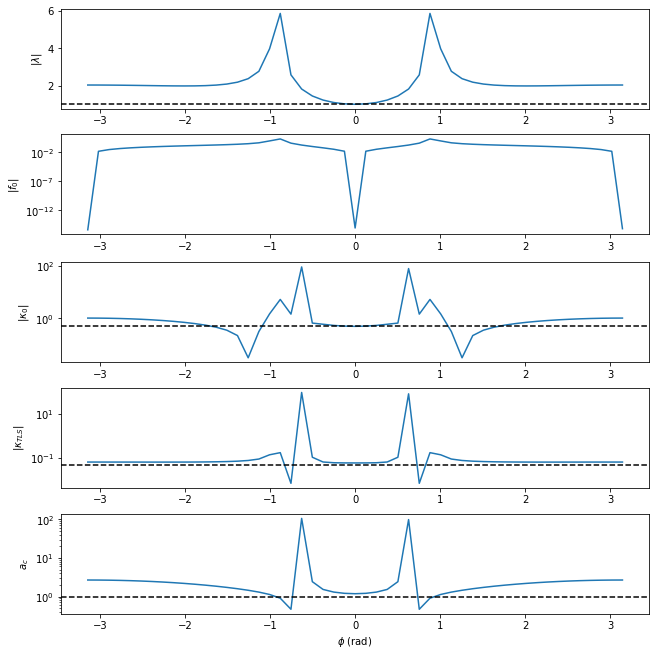

In [31]:
fig, ax = plt.subplots(5, figsize=[9, 9])
ax[0].plot(α_arr, np.abs(λ_α))
ax[0].axhline(y=λ, linestyle='--', color='black')
ax[1].semilogy(α_arr, np.abs(f0_α))
ax[1].axhline(y=f0, linestyle='--', color='black')
ax[2].semilogy(α_arr, np.abs(κ0_α))
ax[2].axhline(y=κ0, linestyle='--', color='black')
ax[3].semilogy(α_arr, np.abs(κtls_α))
ax[3].axhline(y=κtls, linestyle='--', color='black')
ax[4].semilogy(α_arr, ac_α)
ax[4].axhline(y=ac, linestyle='--', color='black')
ax[0].set_ylabel(r'$|\lambda|$')
ax[1].set_ylabel(r'$|f_0|$')
ax[2].set_ylabel(r'$|\kappa_0|$')
ax[3].set_ylabel(r'$|\kappa_{TLS}|$')
ax[4].set_xlabel(r'$\phi$ (rad)')
ax[4].set_ylabel(r'$a_c$')
plt.show()

### Out of resonance simulation

The previous plot indicates that our reconstruction fails when we input the wrong phases.
Therefore we will have to find a way to calculate this phases.
Maybe if we analyze the spectra out of resonance we can get some valuable infomation.

The input-output relation out of resonance is given by

$$ \dfrac{a_{out}}{\sqrt{G}} = e^{i\phi} \dfrac{a_{in}}{\sqrt{\mathcal{A}}}. $$

In the frequency domain:

$$ \dfrac{A_{out,k}}{\sqrt{G}} = e^{i\phi} \dfrac{A_{in,k}}{\sqrt{\mathcal{A}}} \quad \rightarrow \quad e^{i\phi} = \sqrt{\dfrac{\mathcal{A}}{G}} \dfrac{A_{out,k}}{A_{in,k}} $$


We then solve the same differential equation, but with the two drives far from resonance.
We also sweep the phase to check that we are able to reconstruct the phase for several values.
The parameters of the simulation are the following:

| Drive Parameters | System Parameters       |
|:-----------------|:------------------------|
| $F_0 = 1$        | $\omega_r = 0$          |
| $f_1 = 10.000$   | $\kappa_0 = 0.5$        |
| $f_2 = 10.002$   | $\kappa_{TLS} = 0.05$   |
|                  | $a_{c} = 1$             |
|                  | $\phi \in (-\pi,\pi)$   |
|                  | $\lambda = 1$           |

In the figure below, we show the spectra for the two drives out of resonance for $\phi=\pi$.

In [42]:
# Gain and attenuation of the measurement lines
gain = 1
att = 1

# Drive parameters
λ = 1
F0 = 1
f1_or = 10.000
f2_or = 10.002
df = 0.001
fs_or = 40
N = int(round(fs_or/df))
phi_arr = np.linspace(-np.pi, np.pi, 16)

# Drive indices
ind_drive_or = np.array([10000, 10002, -10000, -10002])

# Imps indices
nimps = 0
imp_ind_or = np.arange(ind_drive_or[0]-nimps, ind_drive_or[1]+nimps+2, 2)

# Integration parameters
T = 1. / df
T_relax = 5 * T
dt = 1. / fs_or
t_all_or = dt*(np.arange((T+T_relax)/dt) + 1)

# System parameters
f0 = 0
κ0 = 0.5
κtls = 0.05
ac = 1
Q_factor = 1/(2*κ0)

# Initial conditions
y0 = [0,0]

In [43]:
# Phase sweep
phase = np.zeros(len(phi_arr), dtype=complex)

with tqdm(total=len(phi_arr), ncols=80) as pbar:

    for phi_ind, phi_val in enumerate(phi_arr):
        # Simulation section
        A, Ain, a_all, a, ain, f_or, t_or, drive = nonlinear_simulation(t_all_or, f0, κ0, κtls, ac, λ, f1_or, f2_or, F0, ind_drive_or, phi_val)
        
        phase[phi_ind] = -1.0j * np.log(np.sqrt(att/gain) * A[ind_drive_or[0]]/Ain[ind_drive_or[0]])
        
        pbar.update(1)

100%|████████████████████████████████████████| 16/16 [1:29:49<00:00, 336.85s/it]


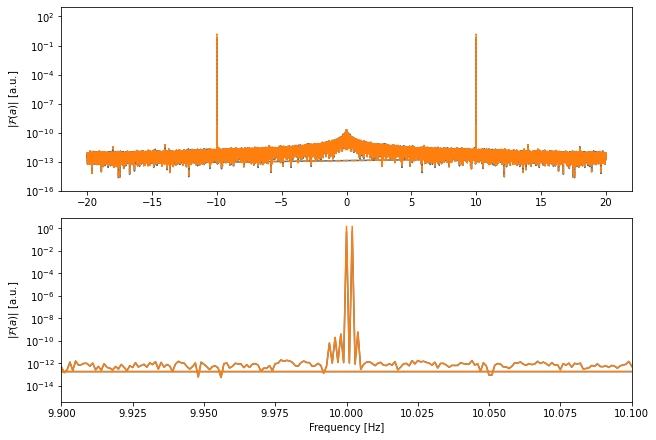

In [44]:
# Plot Fourier spectra of the intra-cavity field
ylim = np.array([1e-16, 1e3])
xlim = np.array([9.9, 10.1])
fig10, ax10 = plt.subplots(2, figsize=(9,6))
ax10[0].semilogy(f_or, np.abs(A))
ax10[0].semilogy(f_or, np.abs(A-Ain), '--')
ax10[1].semilogy(f_or, np.abs(A))
ax10[1].semilogy(f_or, np.abs(A-Ain))
ax10[0].set_ylabel('$|\mathcal{F}(a)|$ [a.u.]')
ax10[1].set_xlabel('Frequency [Hz]')
ax10[1].set_ylabel('$|\mathcal{F}(a)|$ [a.u.]')
ax10[1].set_xlim(*xlim)
ax10[0].set_ylim(*ylim)
plt.show()

We then sweep the phase in the simulation and try to reconstruct.
Here we plot the reconstructed phase difference against the simulated phase difference.
The dotted yellow line represents slope 1, and ideally all the dots should lie on such line.

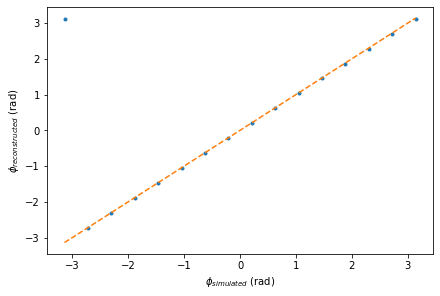

In [45]:
fig11, ax11 = plt.subplots(1)
ax11.plot(phi_arr, np.real(phase), '.')
ax11.plot(phi_arr, phi_arr, '--')
ax11.set_xlabel('$\phi_{simulated}$ (rad)')
ax11.set_ylabel('$\phi_{reconstructed}$ (rad)')
plt.show()

In [41]:
winsound.Beep(540, 1500)